<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/data-preparation/kaggle_etherscan_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [3]:
df_ts = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/time_series_data.csv')
df_ts.head()

,Unnamed: 0,Address,adjusted_eth_value__variance_larger_than_standard_deviation,adjusted_eth_value__has_duplicate_max,adjusted_eth_value__has_duplicate_min,adjusted_eth_value__has_duplicate,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__mean_abs_change,adjusted_eth_value__mean_second_derivative_central,...,adjusted_eth_value__ratio_beyond_r_sigma__r_3,adjusted_eth_value__ratio_beyond_r_sigma__r_5,adjusted_eth_value__ratio_beyond_r_sigma__r_6,adjusted_eth_value__ratio_beyond_r_sigma__r_10,adjusted_eth_value__count_above__t_0,adjusted_eth_value__count_below__t_0,adjusted_eth_value__fourier_entropy__bins_2,adjusted_eth_value__query_similarity_count__query_None__threshold_0.0,"adjusted_eth_value__matrix_profile__feature_""min""__threshold_0.98",FLAG
0,0,0x000000000532b45f47779fce440748893b257865,1.0,0.0,1.0,1.0,0.002552,5587.558824,5.789218,-0.237797,...,0.000000,0.000000,0.000000,0.0,0.869565,0.130435,0.450561,0.0,0.000000,1
1,1,0x00000000072d54638c2c2a3da3f715360269eea1,1.0,0.0,0.0,1.0,-0.771623,52949.011552,10.615707,2.037385,...,0.018868,0.018868,0.018868,0.0,0.811321,0.433962,0.479166,0.0,0.634623,1
2,2,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,1.0,0.0,0.0,0.0,-9.999391,4444.468528,20.771913,-8.228324,...,0.000000,0.000000,0.000000,0.0,0.833333,0.166667,0.562335,0.0,0.000000,1
3,3,0x00000000d029a3ed50d891b9afd74b034179082e,0.0,0.0,0.0,0.0,0.004158,0.495859,0.995842,0.000000,...,0.000000,0.000000,0.000000,0.0,0.500000,0.500000,-0.000000,0.0,0.000000,1
4,4,0x00000e32e51011e28958d4696627c82c3dacd5a6,0.0,0.0,0.0,1.0,-0.035777,0.351082,0.098646,-0.000387,...,0.023256,0.000000,0.000000,0.0,0.720930,0.302326,0.625491,0.0,0.000000,1


In [4]:
df_ts.columns

Index(['Unnamed: 0', 'Address',
       'adjusted_eth_value__variance_larger_than_standard_deviation',
       'adjusted_eth_value__has_duplicate_max',
       'adjusted_eth_value__has_duplicate_min',
       'adjusted_eth_value__has_duplicate', 'adjusted_eth_value__sum_values',
       'adjusted_eth_value__abs_energy', 'adjusted_eth_value__mean_abs_change',
       'adjusted_eth_value__mean_second_derivative_central',
       ...
       'adjusted_eth_value__ratio_beyond_r_sigma__r_3',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_5',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_6',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_10',
       'adjusted_eth_value__count_above__t_0',
       'adjusted_eth_value__count_below__t_0',
       'adjusted_eth_value__fourier_entropy__bins_2',
       'adjusted_eth_value__query_similarity_count__query_None__threshold_0.0',
       'adjusted_eth_value__matrix_profile__feature_"min"__threshold_0.98',
       'FLAG'],
      dtype='object', lengt

In [5]:
add = df_ts[['Address']]
labels = df_ts[['FLAG']]

df_ts.drop_duplicates(subset=["Address"], inplace=True)
df_ts.drop(['Unnamed: 0', 'Address', 'FLAG'], axis=1, inplace=True)

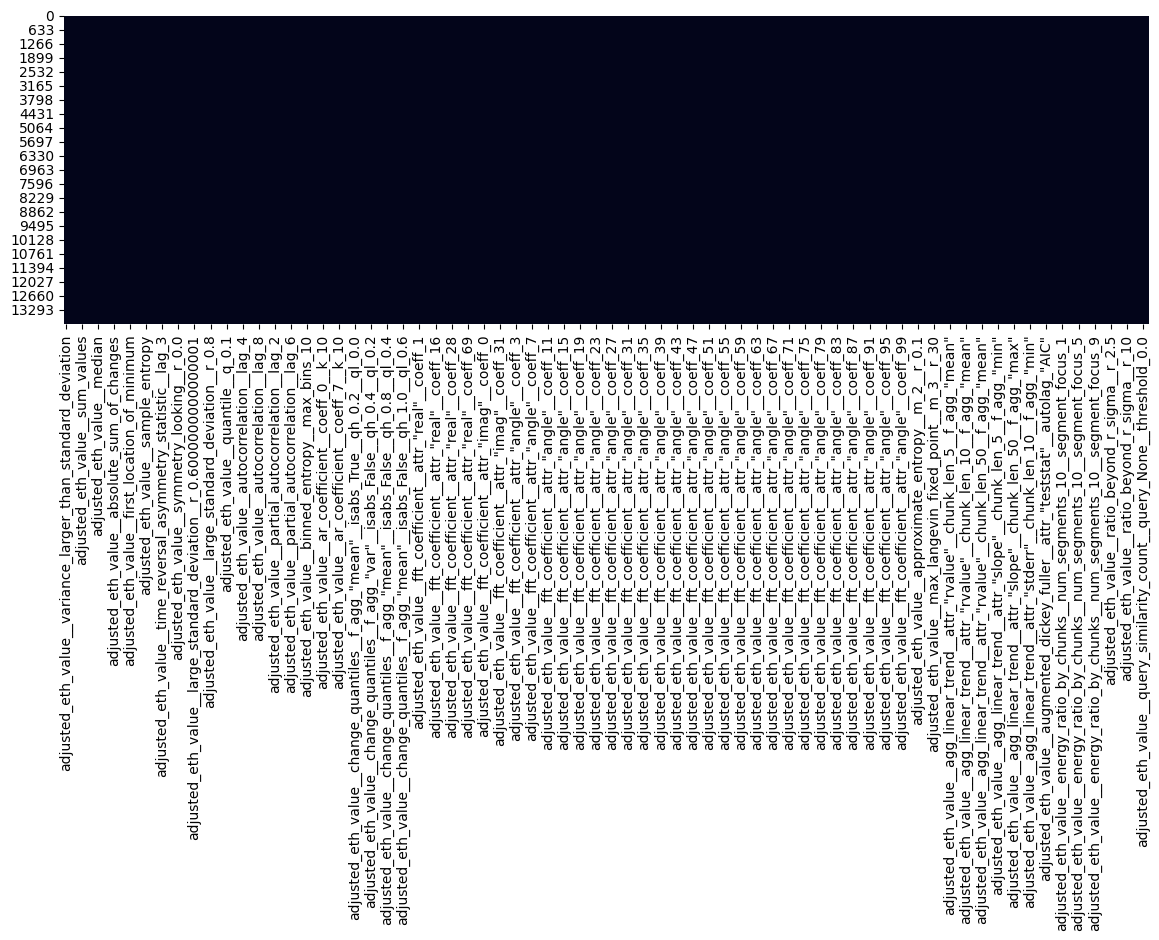

In [6]:
# Visualize missing values
plt.figure(figsize=(14,4))
sns.heatmap(df_ts.isnull(), cbar=False)
plt.show()

In [7]:
positions = df_ts.isin([np.inf, -np.inf])
inf_positions = df_ts.loc[positions.any(axis=1), positions.any(axis=0)]
inf_positions

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,adjusted_eth_value__sample_entropy,"adjusted_eth_value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC"""
15,inf,-9.999457e+00
32,inf,-5.767771e+00
54,inf,-1.479471e+00
67,inf,-1.013845e+00
83,inf,-3.467304e+00
...,...,...
12463,inf,-4.741284e-01
12465,inf,-2.014420e+00
12471,inf,-2.902720e+00
12491,inf,0.000000e+00


In [8]:
# Drop features that contains inf
features_to_drop = ['adjusted_eth_value__sample_entropy','adjusted_eth_value__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"']
df_ts.drop(features_to_drop, axis=1, inplace=True)

# Replace missing values with median
df_ts.fillna(df_ts.median(), inplace=True)

In [9]:
train_x, test_x, train_y, test_y = train_test_split(df_ts, labels, test_size=0.2, random_state=12)
xgb = XGBClassifier(seed=42)

params = {
    'objective': ['binary:logistic'],
    'max_depth': [4],
    'n_estimators': [1000],
    'learning_rate': [0.01],
    'subsample': [0.3],
    'colsample_bytree':[0.3]
}

clf = GridSearchCV(estimator=xgb,
                   param_grid=params,
                   cv=5,
                   n_jobs=-1,
                   scoring='f1')
clf.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'learning_rate': [0.01],
                         'max_depth': [4], 'n_estimators': [1000],
                         'objective': ['binary:logistic'], 'subsample': [0.3]},
             scoring='f1')

In [10]:
features = df_ts.columns.tolist()
feat_importances = clf.best_estimator_.feature_importances_
sorted_indices = np.argsort(feat_importances)[::-1]
sorted_features = [features[idx] for idx in sorted_indices]
sorted_importances = feat_importances[sorted_indices]

for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature} : {importance}")

adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0 : 0.021745754405856133
adjusted_eth_value__absolute_sum_of_changes : 0.019324559718370438
adjusted_eth_value__max_langevin_fixed_point__m_3__r_30 : 0.01930658519268036
adjusted_eth_value__ratio_value_number_to_time_series_length : 0.018907921388745308
adjusted_eth_value__has_duplicate_min : 0.01823323965072632
adjusted_eth_value__mean_abs_change : 0.018090255558490753
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1 : 0.01310151256620884
adjusted_eth_value__count_below__t_0 : 0.012987175956368446
adjusted_eth_value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" : 0.012309351935982704
adjusted_eth_value__autocorrelation__lag_6 : 0.01194225437939167
adjusted_eth_value__matrix_profile__feature_"min"__threshold_0.98 : 0.010993333533406258
adjusted_eth_value__autocorrelation__lag_1 : 0.010098480619490147
adjusted_eth_value__first_location_of_minimum : 0.009719690307974815
ad

In [11]:
top_10_indices = sorted_indices[:10]
top_10_features = [features[idx] for idx in top_10_indices]
top_10_importances = feat_importances[top_10_indices]
top_10_features

['adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
 'adjusted_eth_value__absolute_sum_of_changes',
 'adjusted_eth_value__max_langevin_fixed_point__m_3__r_30',
 'adjusted_eth_value__ratio_value_number_to_time_series_length',
 'adjusted_eth_value__has_duplicate_min',
 'adjusted_eth_value__mean_abs_change',
 'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
 'adjusted_eth_value__count_below__t_0',
 'adjusted_eth_value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
 'adjusted_eth_value__autocorrelation__lag_6']

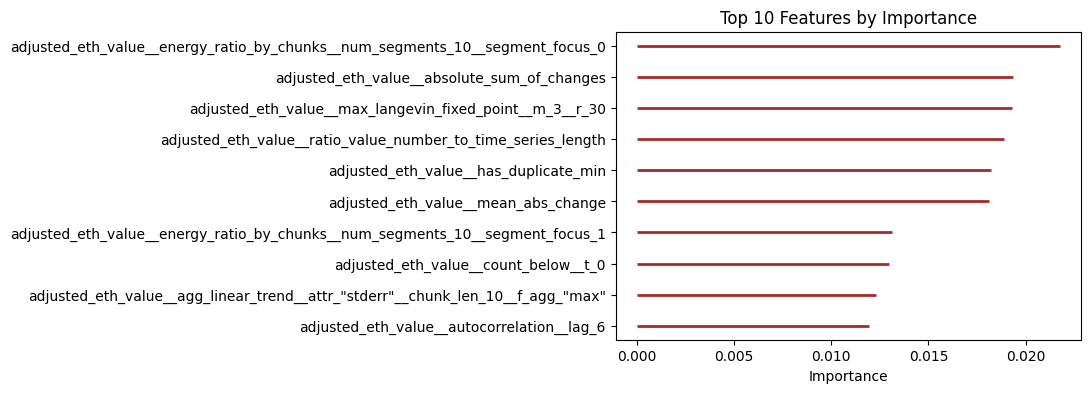

In [12]:
plt.figure(figsize=(6, 4))
plt.title('Top 10 Features by Importance')

# Calculate y positions for the features
y_positions = range(len(top_10_features))

# Draw horizontal lines
plt.hlines(y=y_positions, xmin=0, xmax=top_10_importances, color='brown', linewidth=2)

# Set the labels and invert the y-axis
plt.yticks(y_positions, top_10_features)
plt.xlabel('Importance')
plt.gca().invert_yaxis()

plt.show()


In [14]:
df_ts_new = df_ts[top_10_features]
df_ts_new.insert(0, 'Address', add)
df_ts_new.head()

,Address,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__max_langevin_fixed_point__m_3__r_30,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__has_duplicate_min,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,adjusted_eth_value__count_below__t_0,"adjusted_eth_value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",adjusted_eth_value__autocorrelation__lag_6
0,0x000000000532b45f47779fce440748893b257865,0.022371,127.362801,0.000000,0.695652,1.0,5.789218,0.007417,0.130435,16.657558,-0.123131
1,0x00000000072d54638c2c2a3da3f715360269eea1,0.817820,552.016751,0.000000,0.735849,0.0,10.615707,0.000008,0.433962,17.049386,-0.000112
2,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,0.005625,103.859566,24.257259,1.000000,0.0,20.771913,0.006320,0.166667,0.000000,0.000000
3,0x00000000d029a3ed50d891b9afd74b034179082e,0.504175,0.995842,0.000000,1.000000,0.0,0.995842,0.495825,0.500000,0.000000,0.000000
4,0x00000e32e51011e28958d4696627c82c3dacd5a6,0.006337,4.143127,0.000000,0.674419,0.0,0.098646,0.058109,0.302326,0.030389,-0.138935


In [15]:
df_ke = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_data.csv').drop(columns=['Unnamed: 0'])
df_ke.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,avg val received,min val sent,max val sent,avg val sent,total Ether sent,total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.676667,15159.077780,71235.616670,5,3,0,1,1,0.010000,0.013367,0.000000,0.000000,0.000000,0.000000,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.016667,1124.888889,25126.450000,7,15,0,13,6,0.000000,0.176667,0.145000,1.350000,0.419270,2.934889,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.733333,0.000000,723.466667,2,1,0,1,2,4.999916,4.999916,2.490000,2.509076,2.499538,4.999076,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.600000,1479.855556,45357.566670,1,21,0,21,1,0.035000,0.099286,2.084658,2.084658,2.084658,2.084658,2.085000,0.000342


In [16]:
df_combined = pd.merge(df_ke, df_ts_new, on='Address', how='left')
df_combined.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__max_langevin_fixed_point__m_3__r_30,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__has_duplicate_min,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,adjusted_eth_value__count_below__t_0,"adjusted_eth_value__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",adjusted_eth_value__autocorrelation__lag_6
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.676667,15159.077780,71235.616670,5,3,0,1,1,...,0.358576,0.129900,0.000000,0.470588,0.0,0.008119,0.000000,0.647059,0.00000,-0.268036
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.016667,1124.888889,25126.450000,7,15,0,13,6,...,0.020237,7.669778,0.000000,0.409091,0.0,0.365228,0.033327,0.363636,0.34641,0.601499
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.733333,0.000000,723.466667,2,1,0,1,2,...,0.666738,7.508992,-0.892255,1.000000,0.0,3.754496,0.165359,0.666667,0.00000,0.000000
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.000000,0.000000,0.000000,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.600000,1479.855556,45357.566670,1,21,0,21,1,...,0.006660,3.404658,0.000000,0.409091,0.0,0.162127,0.008042,0.045455,0.00433,-0.044854


In [17]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14155 entries, 0 to 14154
Data columns (total 28 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Address                                                                         14155 non-null  object 
 1   FLAG                                                                            14155 non-null  int64  
 2   Avg min between sent tnx                                                        14155 non-null  float64
 3   Avg min between received tnx                                                    14155 non-null  float64
 4   Time Diff between first and last (Mins)                                         14155 non-null  float64
 5   Sent tnx                                                                        14155 non-null  int64  
 6   Received Tnx  

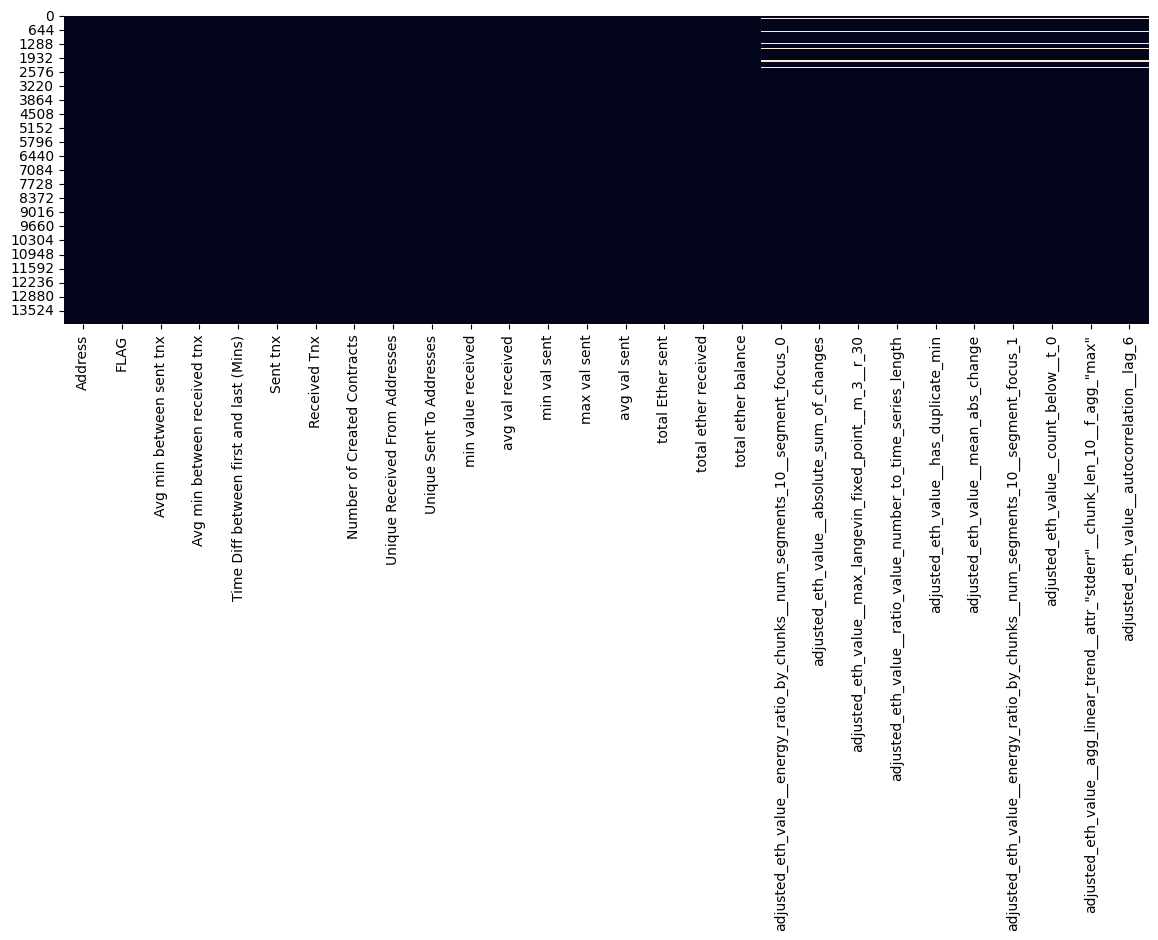

In [18]:
# Visualize missing values
plt.figure(figsize=(14,4))
sns.heatmap(df_combined.isnull(), cbar=False)
plt.show()

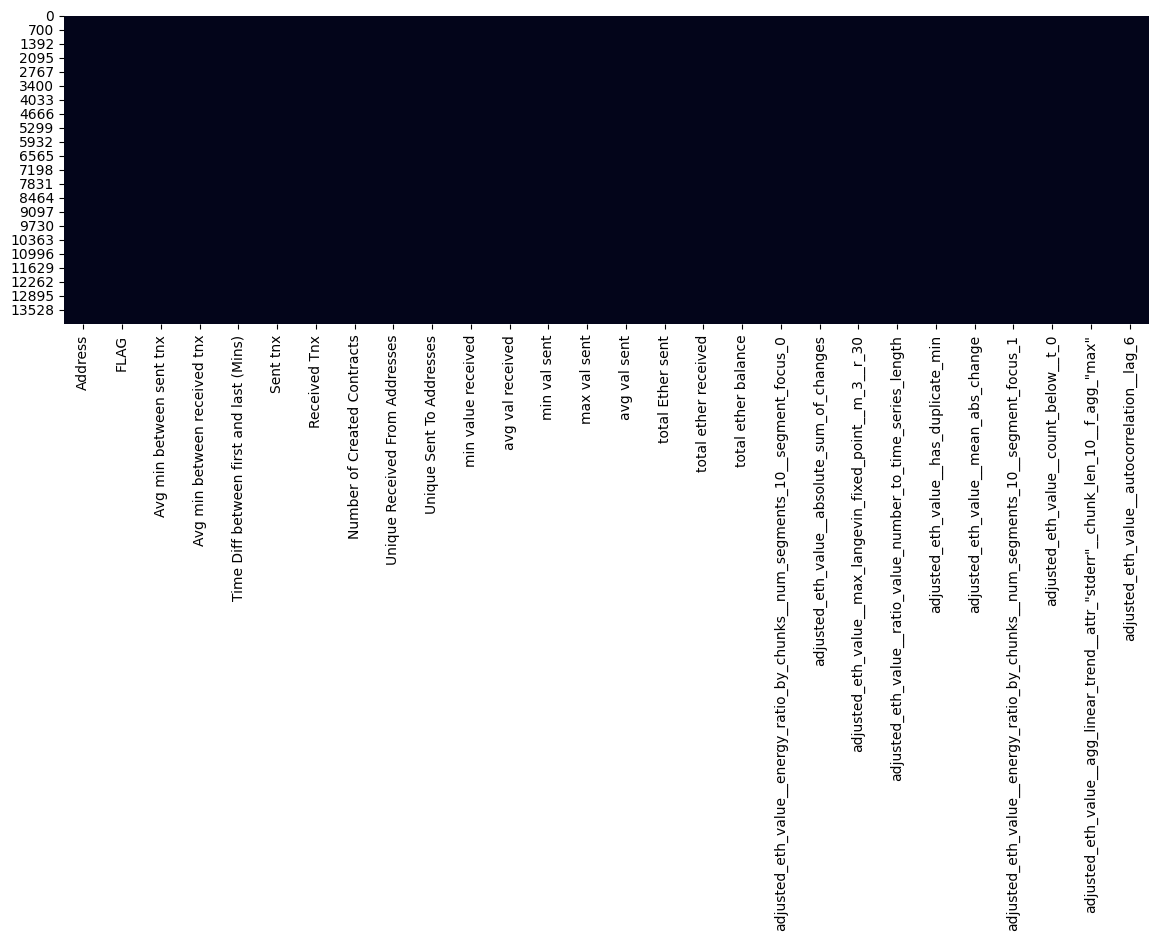

In [19]:
df_combined = df_combined.dropna()

plt.figure(figsize=(14,4))
sns.heatmap(df_combined.isnull(), cbar=False)
plt.show()

In [20]:
# df_combined.to_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_ts_data.csv')